In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
# 배송일수 계산

import pandas as pd

# 1. CSV 불러오기 (경로는 필요 시 변경하세요)
orders = pd.read_csv("clean_olist_orders_dataset.csv", parse_dates=[
    'order_purchase_timestamp', 'order_delivered_customer_date', 'order_estimated_delivery_date'
])
order_items = pd.read_csv("clean_order_items_dataset.csv")
customers = pd.read_csv("clean_customers.csv")
sellers = pd.read_csv("clean_sellers_dataset.csv")
products = pd.read_csv("clean_products_dataset.csv")
category_translation = pd.read_csv("clean_product_category_name_translation.csv")

# 2. 주문 + 주문 품목 병합
df = pd.merge(orders, order_items, on="order_id", how="inner")

# 3. 고객 정보 병합
df = pd.merge(df, customers, on="customer_id", how="left")

# 4. 제품 카테고리 병합
df = pd.merge(df, products[['product_id', 'product_category_name']], on="product_id", how="left")
df = pd.merge(df, category_translation, on="product_category_name", how="left")

# 5. 판매자 정보 병합
df = pd.merge(df, sellers, on="seller_id", how="left")

# 6. 배송 시간 및 지연일 계산
df["shipping_duration_days"] = (df["order_delivered_customer_date"] - df["order_purchase_timestamp"]).dt.days
df["shipping_delay_days"] = (df["order_delivered_customer_date"] - df["order_estimated_delivery_date"]).dt.days

# 7. 배송 정보가 있는 주문만 필터링
df = df[df["order_delivered_customer_date"].notnull()].copy()

# 8. 주요 컬럼 및 10개 데이터 확인
print(df[[
    'order_id', 'order_purchase_timestamp', 'order_delivered_customer_date',
    'order_estimated_delivery_date', 'shipping_duration_days', 'shipping_delay_days',
    'customer_state', 'seller_state', 'product_category_name_english'
]].head(10))

                           order_id order_purchase_timestamp  \
0  e481f51cbdc54678b7cc49136f2d6af7      2017-10-02 10:56:33   
1  53cdb2fc8bc7dce0b6741e2150273451      2018-07-24 20:41:37   
2  47770eb9100c2d0c44946d9cf07ec65d      2018-08-08 08:38:49   
3  949d5b44dbf5de918fe9c16f97b45f8a      2017-11-18 19:28:06   
4  ad21c59c0840e6cb83a9ceb5573f8159      2018-02-13 21:18:39   
5  a4591c265e18cb1dcee52889e2d8acc3      2017-07-09 21:57:05   
6  6514b8ad8028c9f2cc2374ded245783f      2017-05-16 13:10:30   
7  76c6e866289321a7c93b82b54852dc33      2017-01-23 18:29:09   
8  e69bfb5eb88e0ed6a785585b27e16dbf      2017-07-29 11:55:02   
9  e6ce16cb79ec1d90b1da9085a6118aeb      2017-05-16 19:41:10   

  order_delivered_customer_date order_estimated_delivery_date  \
0           2017-10-10 21:25:13                    2017-10-18   
1           2018-08-07 15:27:45                    2018-08-13   
2           2018-08-17 18:06:29                    2018-09-04   
3           2017-12-02 00:28:42    

In [8]:
# 고객별 평균 배송 소요 시간 계산 (배송 완료된 건만)
customer_shipping = df[df["shipping_duration_days"].notnull()].groupby("customer_id")[
    "shipping_duration_days"
].mean().reset_index()

# 컬럼 이름 정리
customer_shipping.rename(columns={"shipping_duration_days": "avg_shipping_duration"}, inplace=True)

# 상위 5개 고객 샘플 출력
print(customer_shipping.head())

                        customer_id  avg_shipping_duration
0  00012a2ce6f8dcda20d059ce98491703                   13.0
1  000161a058600d5901f007fab4c27140                    9.0
2  0001fd6190edaaf884bcaf3d49edf079                    5.0
3  0002414f95344307404f0ace7a26f1d5                   28.0
4  000379cdec625522490c315e70c7a9fb                   11.0


In [4]:
# 배송 지연 건 확인 

# 1. 배송 지연 일수 계산 (선행되어 있지 않다면 반드시 먼저)
df["shipping_delay_days"] = (
    df["order_delivered_customer_date"] - df["order_estimated_delivery_date"]
).dt.days

# 2. 배송 지연 여부 컬럼 추가 (예상보다 하루라도 늦으면 지연)
df["is_late"] = df["shipping_delay_days"] > 0

# 3. 배송 완료된 주문 기준 지연 비율 계산 (NaN은 자동 제외됨)
late_ratio = df["is_late"].mean()

# 4. 출력
print(f"배송 완료된 주문 중 지연된 비율: {late_ratio:.2%}")

배송 완료된 주문 중 지연된 비율: 6.59%


In [ ]:
# 데이터 확인!
df[[
    'order_id', 'order_delivered_customer_date', 'order_estimated_delivery_date',
    'shipping_delay_days', 'is_late'
]].sample(20)

,order_id,order_delivered_customer_date,order_estimated_delivery_date,shipping_delay_days,is_late
100223,e3ca8512cce88f749da2df4e25e22b03,2017-11-30 15:09:23,2017-12-14,-14,False
100620,4b87a2c8b410e2e61c12c83790810587,2017-05-31 21:17:09,2017-06-12,-12,False
461,0f9dc92df0635605588c51ec2e4c58a0,2018-01-10 18:10:04,2018-01-26,-16,False
25212,e703b57c60a71b0b7cae20a5209efea2,2018-04-02 23:26:57,2018-03-20,13,True
82992,6ec4bd1ab5a6833d9129bc04859db56e,2017-11-28 20:55:41,2017-12-13,-15,False
34807,f856b8b90a83c3e6c6bccd3b1665fb79,2017-07-26 15:25:50,2017-08-07,-12,False
14585,dfc7b55ee482374556356b94afc9b841,2018-07-23 15:29:02,2018-08-10,-18,False
19334,6eb1445131218c4f6a6ef2d4960e4f51,2018-06-15 11:14:25,2018-06-28,-13,False
22990,7ce492282af12e4b6c41c28e7b377e87,2017-04-07 12:45:45,2017-04-18,-11,False
55853,918b23cbb191b942f9b138e7aafb295c,2018-01-08 19:34:35,2018-01-12,-4,False


In [36]:
# Customer 지역별 DLV Lead Time

# 배송 완료된 주문만 사용
df_completed = df[df["shipping_duration_days"].notnull()]

# 고객이 거주하는 주(customer_state) 기준 평균 배송 시간 계산
region_shipping = df_completed.groupby("customer_state")["shipping_duration_days"].mean().reset_index()

# 컬럼명 정리
region_shipping.rename(columns={"shipping_duration_days": "avg_shipping_duration"}, inplace=True)

# 평균 배송 시간 기준으로 정렬 (긴 순으로)
region_shipping_sorted = region_shipping.sort_values("avg_shipping_duration", ascending=True)

# 결과 미리보기
print(region_shipping_sorted.head(10))



   customer_state  avg_shipping_duration
25             SP               8.258393
17             PR              11.480793
10             MG              11.514635
6              DF              12.501486
23             SC              14.520986
18             RJ              14.690094
22             RS              14.709183
8              GO              14.948177
11             MS              15.107275
7              ES              15.192809


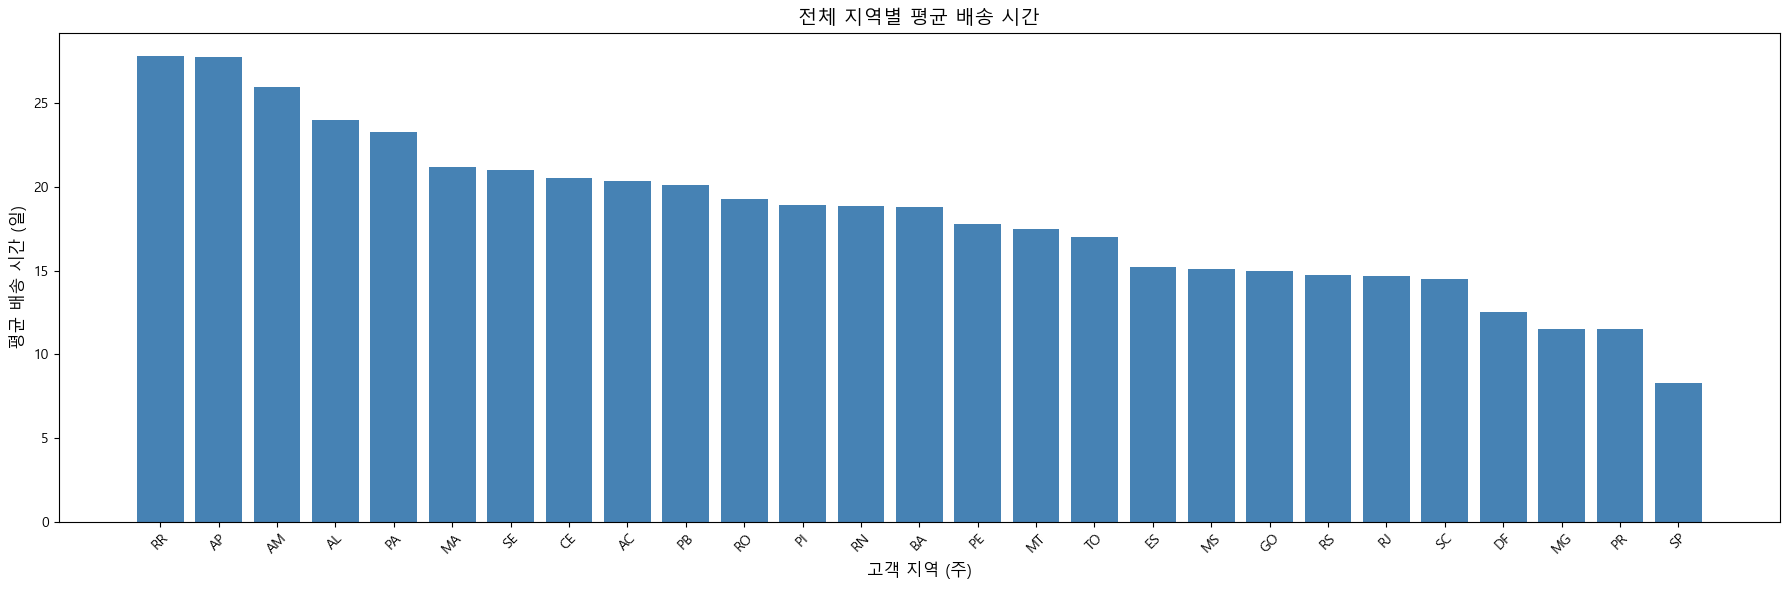

In [ ]:
# Customer 지역별 DLV Lead Time 시각화 자료!

import matplotlib.pyplot as plt

# 1. 데이터 정렬
region_all = region_shipping.sort_values("avg_shipping_duration", ascending=False)

# 2. 그래프 출력
plt.figure(figsize=(18, 6))  # 가로를 넓게 설정 (18 이상 권장)
plt.bar(region_all["customer_state"], region_all["avg_shipping_duration"], color='steelblue')
plt.title("전체 지역별 평균 배송 시간", fontsize=14)
plt.xlabel("고객 지역 (주)", fontsize=12)
plt.ylabel("평균 배송 시간 (일)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
# 브라질 지역 구분 및 적용 코드

# 도시 집중형 (Urban Core)    SP, RJ, DF, MG, RS, PR, BA                  인구·물류 집중
# 중간 규모 (Mid Urban)       SC, PE, GO, CE, ES, PA 등                   인구 적당, 산업 혼합
# 저밀도·외곽 (Remote/Rural)  AM, RR, AC, AP, RO, PI, MA, TO, SE, RN 등   내륙 및 북부 저개발 지역

region_group_map = {
    "SP": "도시 집중형 (Urban Core)", "RJ": "도시 집중형 (Urban Core)", "MG": "도시 집중형 (Urban Core)", "DF": "도시 집중형 (Urban Core)",
    "RS": "도시 집중형 (Urban Core)", "PR": "도시 집중형 (Urban Core)", "BA": "도시 집중형 (Urban Core)",
    "SC": "중간 규모 (Mid Urban)", "PE": "중간 규모 (Mid Urban)", "GO": "중간 규모 (Mid Urban)",
    "CE": "중간 규모 (Mid Urban)", "ES": "중간 규모 (Mid Urban)", "PA": "중간 규모 (Mid Urban)",
    "AM": "저밀도 외곽 (Remote)", "RR": "저밀도 외곽 (Remote)", "AC": "저밀도 외곽 (Remote)",
    "AP": "저밀도 외곽 (Remote)", "RO": "저밀도 외곽 (Remote)", "PI": "저밀도 외곽 (Remote)",
    "MA": "저밀도 외곽 (Remote)", "TO": "저밀도 외곽 (Remote)", "SE": "저밀도 외곽 (Remote)", "RN": "저밀도 외곽 (Remote)"
}

df["region_group"] = df["customer_state"].map(region_group_map)

In [30]:
# 고객 거주지 유형 별 DLV Lead Time

# 분류 컬럼 추가
df["region_group"] = df["customer_state"].map(region_group_map)

# 그룹별 평균 배송 시간 비교
df.groupby("region_group")["shipping_duration_days"].mean()

region_group
도시 집중형 (Urban Core)    10.881177
저밀도 외곽 (Remote)        20.331867
중간 규모 (Mid Urban)      16.549006
Name: shipping_duration_days, dtype: float64

In [ ]:
# 고객 별 거주지 분포도 (설정 그룹)

# 고객 데이터 불러오기
df_customers = pd.read_csv("clean_customers.csv")  # 경로가 다르면 조정

# 지역 그룹 컬럼 추가
df_customers["region_group"] = df_customers["customer_state"].map(region_group_map)

# 그룹별 고객 비율 계산 및 출력
group_dist = df_customers["region_group"].value_counts(normalize=True).sort_values(ascending=False) * 100
group_dist = group_dist.round(2)

# 보기 좋게 출력
for group, pct in group_dist.items():
    print(f"{group}: {pct:.2f}%")

도시 집중형 (Urban Core): 84.92%
중간 규모 (Mid Urban): 12.03%
저밀도 외곽 (Remote): 3.05%


In [ ]:
# 판매자 지역 분포 현황 (주 기준)

# 1. 판매자 데이터 불러오기
df_sellers = pd.read_csv("clean_sellers_dataset.csv")

# 2. 판매자 분포 확인 (주 기준)
seller_dist = df_sellers["seller_state"].value_counts().sort_values(ascending=False)
print(seller_dist)

seller_state
SP    1849
PR     349
MG     244
SC     190
RJ     171
RS     129
GO      40
DF      30
ES      23
BA      19
CE      13
PE       9
PB       6
MS       5
RN       5
MT       4
RO       2
SE       2
AC       1
PI       1
MA       1
AM       1
PA       1
Name: count, dtype: int64


In [ ]:
# 셀러 별 거주지 분포도 (설정 그룹)

# 1. 데이터 불러오기
df_sellers = pd.read_csv("clean_sellers_dataset.csv")  # 파일 경로 조정 필요 시 수정

# 3. 지역 그룹 컬럼 추가
df_sellers["region_group"] = df_sellers["seller_state"].map(region_group_map)

# 4. 그룹별 비율 계산
seller_group_dist = df_sellers["region_group"].value_counts(normalize=True).sort_values(ascending=False) * 100
seller_group_dist = seller_group_dist.round(2)

# 5. 보기 좋게 출력
print("📦 판매자 지역 그룹별 분포 비율:\n")
for group, pct in seller_group_dist.items():
    print(f"{group}: {pct:.2f}%")

📦 판매자 지역 그룹별 분포 비율:

도시 집중형 (Urban Core): 90.62%
중간 규모 (Mid Urban): 8.96%
저밀도 외곽 (Remote): 0.42%


In [68]:
import pandas as pd

# CSV 또는 데이터프레임 불러오기 (예시)
customers = pd.read_csv("olist_customers_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")

# 📍 지역 코드 → 그룹명 매핑 정의
region_group_map = {
    # 도시 집중형 (Urban Core)
    "SP": "도시 집중형", "RJ": "도시 집중형", "MG": "도시 집중형", "DF": "도시 집중형",
    "RS": "도시 집중형", "PR": "도시 집중형", "BA": "도시 집중형",
    
    # 중간 규모 (Mid Urban)
    "SC": "중간 규모", "PE": "중간 규모", "GO": "중간 규모",
    "CE": "중간 규모", "ES": "중간 규모", "PA": "중간 규모",
    "PB": "중간 규모", "AL": "중간 규모",
    
    # 저밀도 외곽 (Remote)
    "AM": "저밀도 외곽", "RR": "저밀도 외곽", "AC": "저밀도 외곽",
    "AP": "저밀도 외곽", "RO": "저밀도 외곽", "PI": "저밀도 외곽",
    "MA": "저밀도 외곽", "TO": "저밀도 외곽", "SE": "저밀도 외곽", "RN": "저밀도 외곽",
    "MT": "저밀도 외곽", "MS": "저밀도 외곽"
}

# 📦 고객 지역 그룹 분포
customers["region_group"] = customers["customer_state"].map(region_group_map).fillna("기타")
customer_group_count = customers.groupby("region_group").size().reset_index(name="customer_count")

# 🏬 셀러 지역 그룹 분포
sellers["region_group"] = sellers["seller_state"].map(region_group_map).fillna("기타")
seller_group_count = sellers.groupby("region_group").size().reset_index(name="seller_count")

# 📊 출력
print("📦 고객 지역 그룹 분포:")
print(customer_group_count.to_markdown(index=False))

print("\n🏬 셀러 지역 그룹 분포:")
print(seller_group_count.to_markdown(index=False))

📦 고객 지역 그룹 분포:
| region_group   |   customer_count |
|:---------------|-----------------:|
| 도시 집중형    |            82264 |
| 저밀도 외곽    |             4575 |
| 중간 규모      |            12602 |

🏬 셀러 지역 그룹 분포:
| region_group   |   seller_count |
|:---------------|---------------:|
| 도시 집중형    |           2791 |
| 저밀도 외곽    |             22 |
| 중간 규모      |            282 |


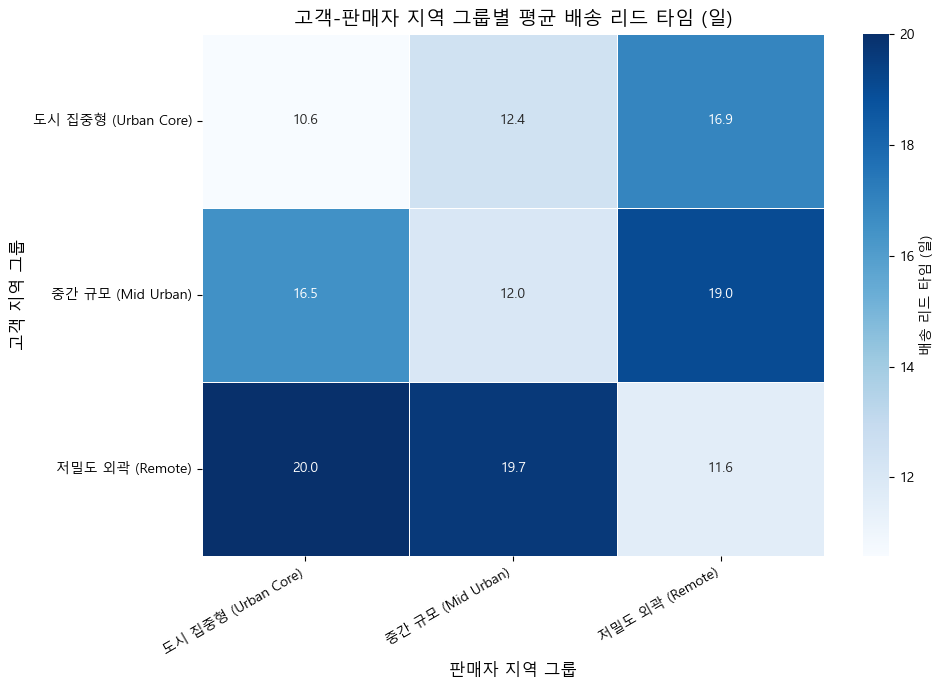

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# 정렬 순서 지정
region_order = ['도시 집중형 (Urban Core)', '중간 규모 (Mid Urban)', '저밀도 외곽 (Remote)']

# 피벗 테이블 정렬
pivot_table = group_shipping_summary.pivot(
    index='customer_region_group',
    columns='seller_region_group',
    values='shipping_duration_days'
).loc[region_order, region_order]

# 시각화
plt.figure(figsize=(10, 7))
sns.heatmap(
    pivot_table,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    linewidths=0.5,
    cbar_kws={'label': '배송 리드 타임 (일)'}
)

# 제목 및 축 설정
plt.title("고객-판매자 지역 그룹별 평균 배송 리드 타임 (일)", fontsize=14)
plt.xlabel("판매자 지역 그룹", fontsize=12)
plt.ylabel("고객 지역 그룹", fontsize=12)

# ✅ 라벨 명확하게 표시
plt.xticks(ticks=[0.5, 1.5, 2.5], labels=region_order, rotation=30, ha='right')
plt.yticks(ticks=[0.5, 1.5, 2.5], labels=region_order, rotation=0)

plt.tight_layout()
plt.show()

|               | 도시 집중형 | 중간 규모  | 저밀도 외곽 |
| ------------- | ----------- | ---------- | ------------ |
| **도시 집중형**  | ✅ 10.6     | ✅ 12.4     | ✅ 16.9       |
| **중간 규모**   | ✅ 16.5     | ✅ 12.0     | ✅ 19.0       |
| **저밀도 외곽**  | ✅ 20.0     | ✅ 19.7     | ✅ 11.6       |

In [89]:
import pandas as pd

# 📂 정제된 데이터 불러오기
df_customers = pd.read_csv("clean_customers.csv")
df_sellers = pd.read_csv("clean_sellers_dataset.csv")
df_orders = pd.read_csv("clean_olist_orders_dataset.csv", parse_dates=["order_purchase_timestamp", "order_delivered_customer_date"])
df_order_items = pd.read_csv("clean_order_items_dataset.csv")

# 🧮 배송 소요 시간 계산
df_orders["shipping_duration_days"] = (df_orders["order_delivered_customer_date"] - df_orders["order_purchase_timestamp"]).dt.days

# 🧷 order_id 기준으로 customer_id 연결
df = df_order_items.merge(df_orders[["order_id", "customer_id", "shipping_duration_days"]], on="order_id", how="left")

# 👤 고객 주 정보 연결
df = df.merge(df_customers[["customer_id", "customer_state"]], on="customer_id", how="left")

# 🛒 셀러 주 정보 연결
df = df.merge(df_sellers[["seller_id", "seller_state"]], on="seller_id", how="left")

# 🔍 조합별 평균 배송 일수 계산
shipping_by_pair = df.groupby(["customer_state", "seller_state"])["shipping_duration_days"].mean().reset_index()

# 🔁 피벗 테이블 형태로 변경
shipping_pivot = shipping_by_pair.pivot(index="customer_state", columns="seller_state", values="shipping_duration_days")

# 📋 결과 출력
print(shipping_pivot.round(1))

seller_state      AM    BA     CE    DF    ES    GO    MA    MG    MS    MT  \
customer_state                                                                
AC               NaN  66.0    NaN  11.0   NaN  18.0  15.0  22.2  19.0   NaN   
AL              90.0  15.7   19.0  13.0   NaN  19.1  29.8  21.7   NaN   NaN   
AM               NaN  33.0  138.0   NaN   NaN  32.0  15.0  25.3   NaN   NaN   
AP               NaN  20.5    NaN   NaN   NaN  24.0  28.0  24.7   NaN   NaN   
BA               NaN  10.7   19.3  18.0  12.7  13.8  21.5  17.7  30.7  13.8   
CE               NaN  15.0    5.9  23.4  13.0  18.3  12.7  19.6   NaN  24.0   
DF               NaN  11.1    9.0   5.6  18.0   8.8  15.7  11.1  10.0  10.7   
ES               NaN  13.2   18.3  19.4   7.6  14.6  28.0  15.6   NaN  21.5   
GO               NaN  17.5   13.0   8.8  12.7   4.9  20.8  13.5  11.0  11.4   
MA              29.0  24.6   21.0  17.8  15.5  17.3  10.1  19.7   NaN  19.3   
MG              23.0  10.1   12.2   9.1  10.0  10.5 

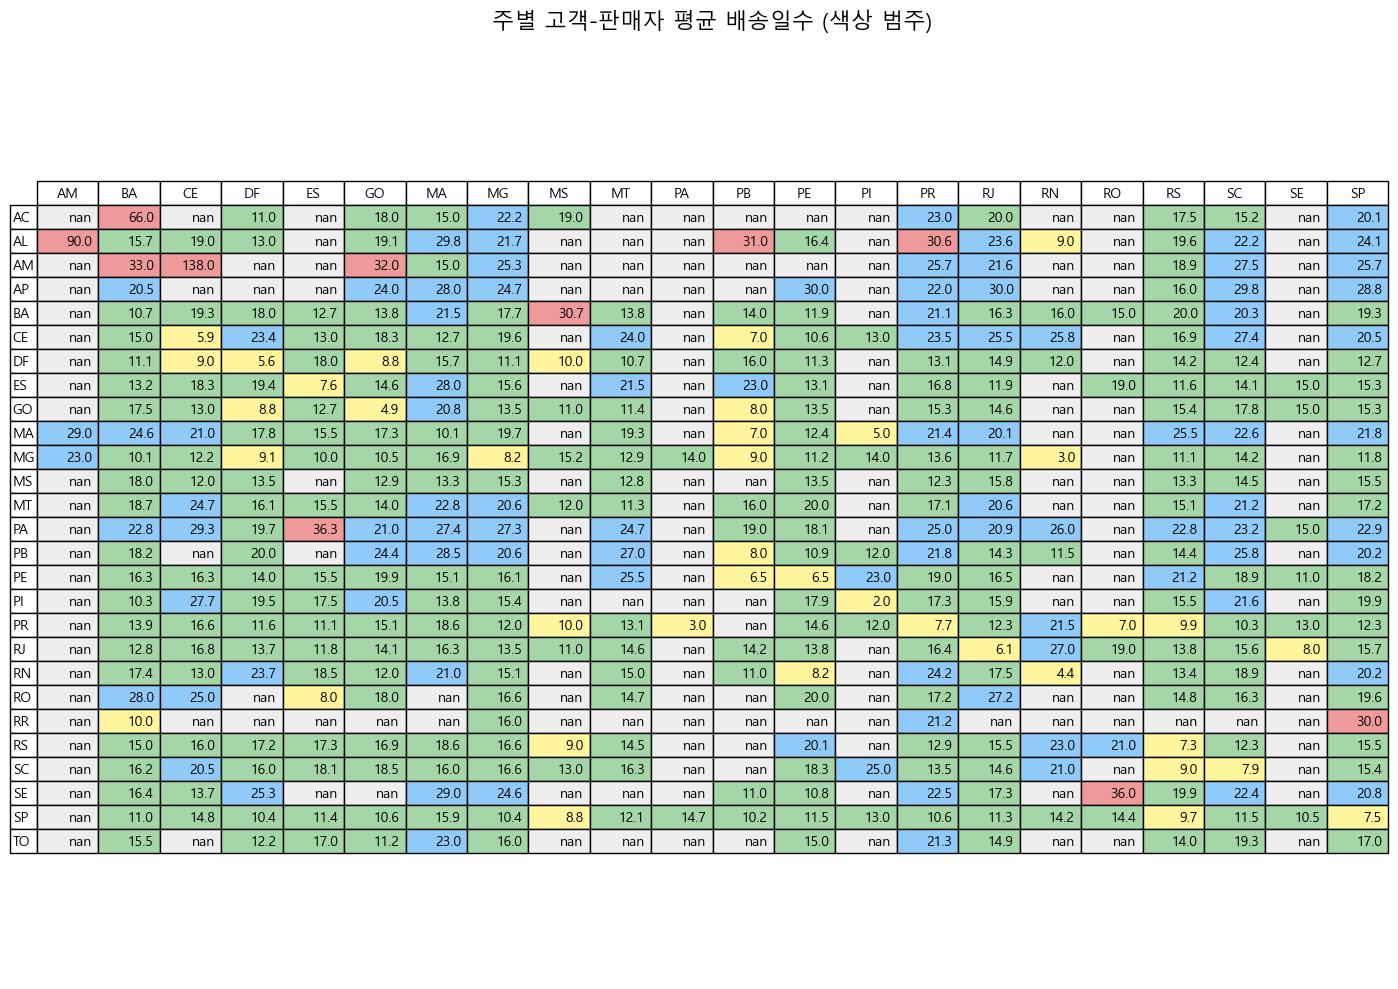

In [90]:
import matplotlib.pyplot as plt
import numpy as np

# 🎨 색상 매핑 함수
def get_color(val):
    if pd.isna(val):
        return '#EEEEEE'  # 회색
    elif val <= 10:
        return '#FFF59D'  # 노랑
    elif val <= 20:
        return '#A5D6A7'  # 초록
    elif val <= 30:
        return '#90CAF9'  # 파랑
    else:
        return '#EF9A9A'  # 빨강

# 📏 시각화용 배열 만들기
vals = shipping_pivot.values
colors = np.empty(vals.shape, dtype=object)

# 색상 매트릭스 채우기
for i in range(vals.shape[0]):
    for j in range(vals.shape[1]):
        colors[i, j] = get_color(vals[i, j])

# 📊 시각화
fig, ax = plt.subplots(figsize=(14, 10))
table = ax.table(
    cellText=np.round(vals, 1),
    rowLabels=shipping_pivot.index,
    colLabels=shipping_pivot.columns,
    cellColours=colors,
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
ax.axis('off')
plt.title("주별 고객-판매자 평균 배송일수 (색상 범주)", fontsize=16, pad=20)
plt.tight_layout()
plt.show()

In [91]:
shipping_pivot = shipping_by_pair.pivot(index="customer_state", columns="seller_state", values="shipping_duration_days")
# 📌 10일 이하인 조합 추출
fast_shipping_pairs = shipping_by_pair[shipping_by_pair["shipping_duration_days"] <= 10]

# 📋 결과 정렬
fast_shipping_pairs_sorted = fast_shipping_pairs.sort_values("shipping_duration_days")

# 📤 결과 확인
print(fast_shipping_pairs_sorted)

    customer_state seller_state  shipping_duration_days
255             PI           PI                2.000000
165             MG           RN                3.000000
270             PR           PA                3.000000
312             RN           RN                4.375000
119             GO           GO                4.948718
143             MA           PI                5.000000
83              DF           DF                5.622951
65              CE           CE                5.888889
293             RJ           RJ                6.120626
239             PE           PE                6.458333
238             PE           PB                6.500000
276             PR           RO                7.000000
72              CE           PB                7.000000
141             MA           PB                7.000000
346             RS           RS                7.252336
399             SP           SP                7.461091
101             ES           ES                7

📊 배송 구간별 평균 리뷰 점수:

shipping_range
~5일       4.43
6~10일     4.35
11~20일    4.19
21~30일    3.58
30일 초과    2.17
Name: review_score, dtype: float64


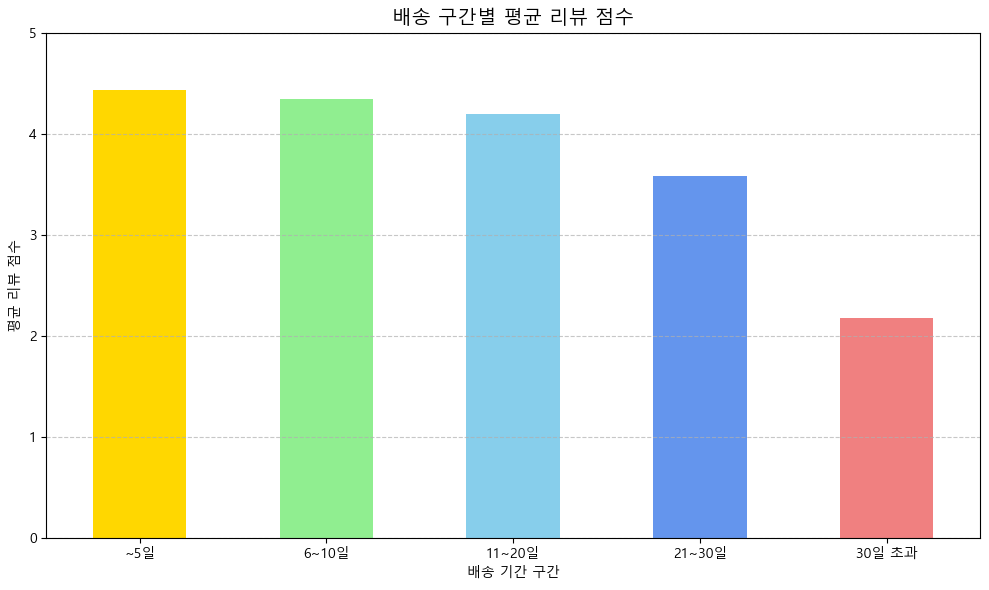

In [92]:
import pandas as pd
import matplotlib.pyplot as plt

# 📂 데이터 불러오기
df_orders = pd.read_csv("clean_olist_orders_dataset.csv", parse_dates=["order_purchase_timestamp", "order_delivered_customer_date"])
df_reviews = pd.read_csv("clean_order_reviews_dataset.csv")

# 🧮 배송일 계산
df_orders["shipping_duration_days"] = (df_orders["order_delivered_customer_date"] - df_orders["order_purchase_timestamp"]).dt.days

# ✅ 리뷰와 주문 병합
df = pd.merge(df_orders[["order_id", "shipping_duration_days"]], df_reviews[["order_id", "review_score"]], on="order_id", how="inner")

# 🚫 결측치 제거
df = df.dropna(subset=["shipping_duration_days", "review_score"])

# 📊 배송일 구간 분류
def classify_shipping_days(days):
    if days <= 5:
        return "~5일"
    elif days <= 10:
        return "6~10일"
    elif days <= 20:
        return "11~20일"
    elif days <= 30:
        return "21~30일"
    else:
        return "30일 초과"

df["shipping_range"] = df["shipping_duration_days"].apply(classify_shipping_days)

# 📈 배송일 구간별 평균 리뷰 점수 계산
avg_scores = df.groupby("shipping_range")["review_score"].mean().reindex(["~5일", "6~10일", "11~20일", "21~30일", "30일 초과"])

# 📋 결과 출력
print("📊 배송 구간별 평균 리뷰 점수:\n")
print(avg_scores.round(2))

# 🎨 시각화
plt.figure(figsize=(10, 6))
avg_scores.plot(kind="bar", color=["gold", "lightgreen", "skyblue", "cornflowerblue", "lightcoral"])
plt.title("배송 구간별 평균 리뷰 점수", fontsize=14)
plt.ylabel("평균 리뷰 점수")
plt.xlabel("배송 기간 구간")
plt.ylim(0, 5)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [98]:
pip install osmnx

  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
Using cached networkx-3.5-py3-none-any.whl (2.0 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


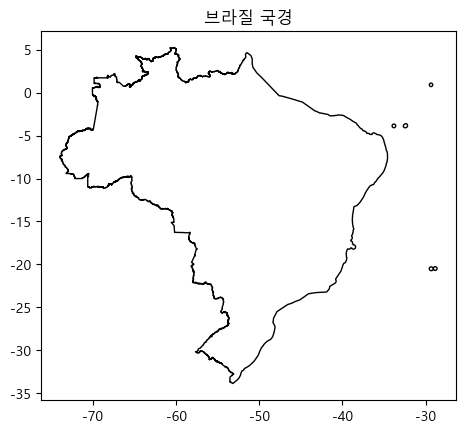

In [99]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt

# 브라질 경계 정보 가져오기
brazil = ox.geocode_to_gdf("Brazil")

# 시각화
brazil.plot(edgecolor='black', facecolor='none')
plt.title("브라질 국경")
plt.show()

In [101]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# 도시 집중형 주 위도(lat), 경도(lng)
urban_states = {
    "SP": (-23.55, -46.63),  # São Paulo
    "RJ": (-22.91, -43.17),  # Rio de Janeiro
    "MG": (-19.92, -43.94),  # Minas Gerais
    "DF": (-15.78, -47.93),  # Distrito Federal
    "RS": (-30.03, -51.23),  # Rio Grande do Sul
    "PR": (-25.43, -49.27),  # Paraná
    "BA": (-12.97, -38.50),  # Bahia
}

# 📍 DataFrame → GeoDataFrame
df_urban = pd.DataFrame(urban_states.items(), columns=["state", "lat_lng"])
df_urban[["lat", "lng"]] = pd.DataFrame(df_urban["lat_lng"].tolist(), index=df_urban.index)
df_urban["geometry"] = df_urban.apply(lambda row: Point(row["lng"], row["lat"]), axis=1)

gdf_urban = gpd.GeoDataFrame(df_urban, geometry="geometry", crs="EPSG:4326")

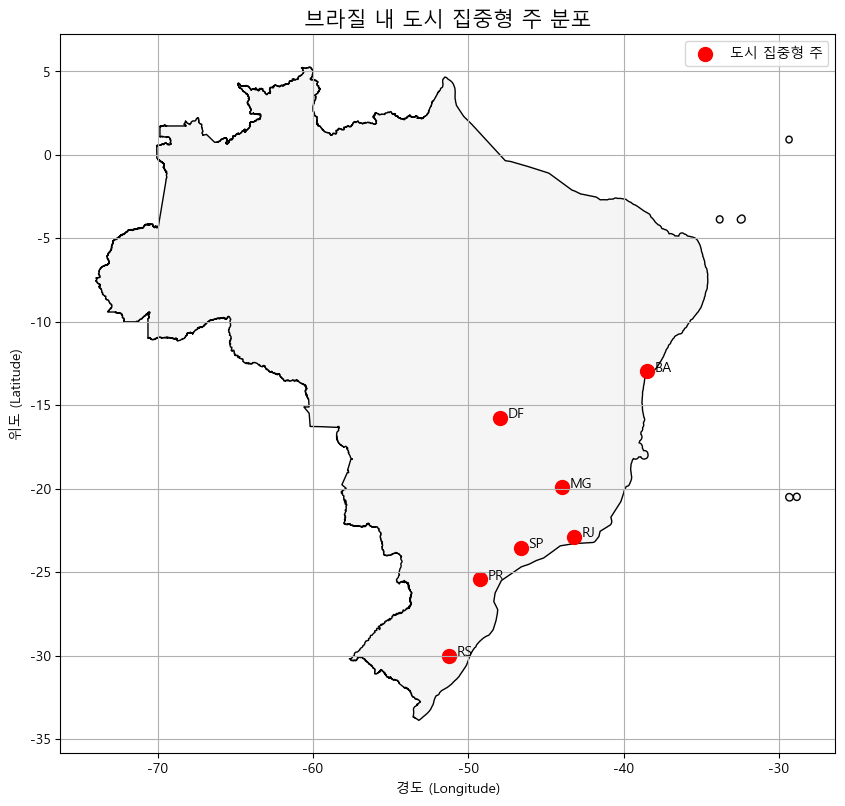

In [102]:
import osmnx as ox

# 🗺️ 브라질 지도 가져오기 (이미 완료한 경우 생략 가능)
brazil = ox.geocode_to_gdf("Brazil")

# 🎯 시각화
fig, ax = plt.subplots(figsize=(10, 10))

# 브라질 지도
brazil.plot(ax=ax, color='whitesmoke', edgecolor='black')

# 도시 집중형 주 마커
gdf_urban.plot(ax=ax, color='red', markersize=100, label="도시 집중형 주")

# 주 이름 라벨링
for x, y, label in zip(gdf_urban.geometry.x, gdf_urban.geometry.y, gdf_urban["state"]):
    ax.text(x + 0.5, y, label, fontsize=10)

plt.title("브라질 내 도시 집중형 주 분포", fontsize=15)
plt.xlabel("경도 (Longitude)")
plt.ylabel("위도 (Latitude)")
plt.legend()
plt.grid(True)
plt.show()

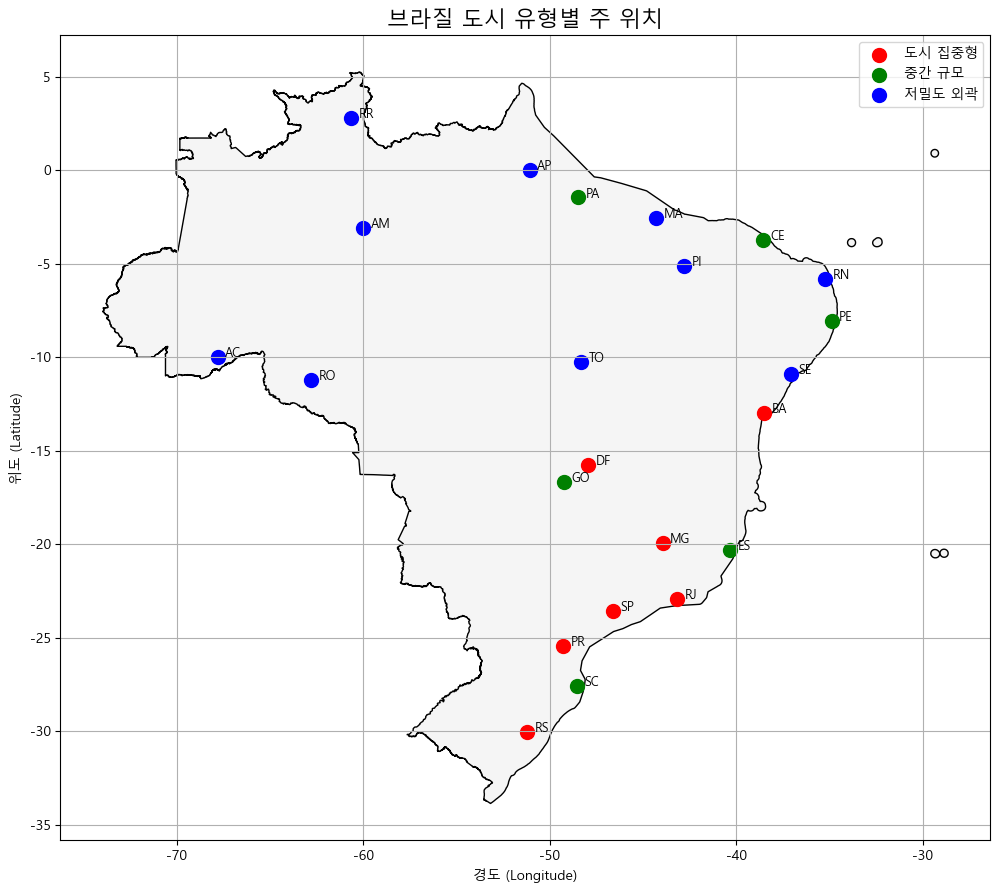

In [105]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import osmnx as ox

# 🏙️ 도시 유형별 주 위도(lat), 경도(lng)
urban_core = {
    "SP": (-23.55, -46.63), "RJ": (-22.91, -43.17), "MG": (-19.92, -43.94),
    "DF": (-15.78, -47.93), "RS": (-30.03, -51.23), "PR": (-25.43, -49.27), "BA": (-12.97, -38.50)
}
mid_urban = {
    "SC": (-27.60, -48.55), "PE": (-8.05, -34.88), "GO": (-16.67, -49.25),
    "CE": (-3.72, -38.54), "ES": (-20.32, -40.34), "PA": (-1.45, -48.49)
}
remote = {
    "AM": (-3.10, -60.02), "RR": (2.82, -60.67), "AC": (-9.97, -67.81), "AP": (0.03, -51.07),
    "RO": (-11.22, -62.80), "PI": (-5.09, -42.80), "MA": (-2.53, -44.30),
    "TO": (-10.25, -48.32), "SE": (-10.91, -37.07), "RN": (-5.80, -35.21)
}

# 🔄 그룹별 GeoDataFrame 생성 함수
def make_gdf(group_dict, group_name):
    df = pd.DataFrame(group_dict.items(), columns=["state", "lat_lng"])
    df[["lat", "lng"]] = pd.DataFrame(df["lat_lng"].tolist(), index=df.index)
    df["도시유형"] = group_name
    df["geometry"] = df.apply(lambda row: Point(row["lng"], row["lat"]), axis=1)
    return gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

gdf_urban = make_gdf(urban_core, "도시 집중형")
gdf_mid = make_gdf(mid_urban, "중간 규모")
gdf_remote = make_gdf(remote, "저밀도 외곽")

# 📌 모두 병합
gdf_all = pd.concat([gdf_urban, gdf_mid, gdf_remote])

# 🗺️ 브라질 지도 가져오기
brazil = ox.geocode_to_gdf("Brazil")

# 🎯 시각화
fig, ax = plt.subplots(figsize=(12, 12))

# 브라질 지도
brazil.plot(ax=ax, color='whitesmoke', edgecolor='black')

# 도시유형별 마커
gdf_urban.plot(ax=ax, color='red', markersize=100, label="도시 집중형")
gdf_mid.plot(ax=ax, color='green', markersize=100, label="중간 규모")
gdf_remote.plot(ax=ax, color='blue', markersize=100, label="저밀도 외곽")

# 주 이름 라벨링
for x, y, label in zip(gdf_all.geometry.x, gdf_all.geometry.y, gdf_all["state"]):
    ax.text(x + 0.4, y, label, fontsize=9)

# 스타일
plt.title("브라질 도시 유형별 주 위치", fontsize=16)
plt.xlabel("경도 (Longitude)")
plt.ylabel("위도 (Latitude)")
plt.legend()
plt.grid(True)
plt.show()

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import osmnx as ox

In [2]:
# 📂 데이터 불러오기
df_customers = pd.read_csv("clean_customers.csv")
df_sellers = pd.read_csv("clean_sellers_dataset.csv")
df_orders = pd.read_csv("clean_olist_orders_dataset.csv", parse_dates=["order_purchase_timestamp", "order_delivered_customer_date"])
df_order_items = pd.read_csv("clean_order_items_dataset.csv")

# 🧮 배송 소요 시간 계산
df_orders["shipping_duration_days"] = (df_orders["order_delivered_customer_date"] - df_orders["order_purchase_timestamp"]).dt.days

# 🧷 order_id로 배송정보와 고객정보 연결
df_temp = df_order_items.merge(
    df_orders[["order_id", "customer_id", "shipping_duration_days"]],
    on="order_id", how="left"
)

df_temp = df_temp.merge(
    df_customers[["customer_id", "customer_state"]],
    on="customer_id", how="left"
)

In [3]:
# 📦 주별 배송 건수 집계
delivery_counts = df_temp.groupby("customer_state").size().reset_index(name="count")

In [4]:
# 🌍 브라질 주 유형 정의
urban_states = {
    "SP": (-23.55, -46.63), "RJ": (-22.91, -43.17), "MG": (-19.92, -43.94), 
    "DF": (-15.78, -47.93), "RS": (-30.03, -51.23), "PR": (-25.43, -49.27), "BA": (-12.97, -38.50)
}

mid_states = {
    "GO": (-16.68, -49.25), "SC": (-27.59, -48.55), "CE": (-3.72, -38.54), "PA": (-1.46, -48.49),
    "PE": (-8.05, -34.88), "ES": (-20.32, -40.34)
}

low_states = {
    "AM": (-3.10, -60.02), "MT": (-15.60, -56.10), "MS": (-20.47, -54.62), "RO": (-11.22, -62.80),
    "AC": (-9.97, -67.80), "RR": (1.30, -60.70), "AP": (0.03, -51.07), "PI": (-5.09, -42.80),
    "MA": (-2.53, -44.30), "TO": (-10.25, -48.33), "SE": (-10.91, -37.07), "RN": (-5.79, -35.20),
    "PB": (-7.12, -34.86), "AL": (-9.66, -35.74)
}

# 📍 GeoDataFrame 생성 함수
def create_gdf(state_dict, group_name):
    df = pd.DataFrame(state_dict.items(), columns=["state", "lat_lng"])
    df[["lat", "lng"]] = pd.DataFrame(df["lat_lng"].tolist(), index=df.index)
    df["group"] = group_name
    df["geometry"] = df.apply(lambda row: Point(row["lng"], row["lat"]), axis=1)
    return gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

# 📍 도시유형별 GeoDataFrame 생성
gdf_urban = create_gdf(urban_states, "도시 집중형")
gdf_mid = create_gdf(mid_states, "중간 규모")
gdf_low = create_gdf(low_states, "저밀도 외곽")

# 🔗 결합 + 배송 건수 merge
gdf_all = pd.concat([gdf_urban, gdf_mid, gdf_low])
gdf_all = gdf_all.merge(delivery_counts, how="left", left_on="state", right_on="customer_state")

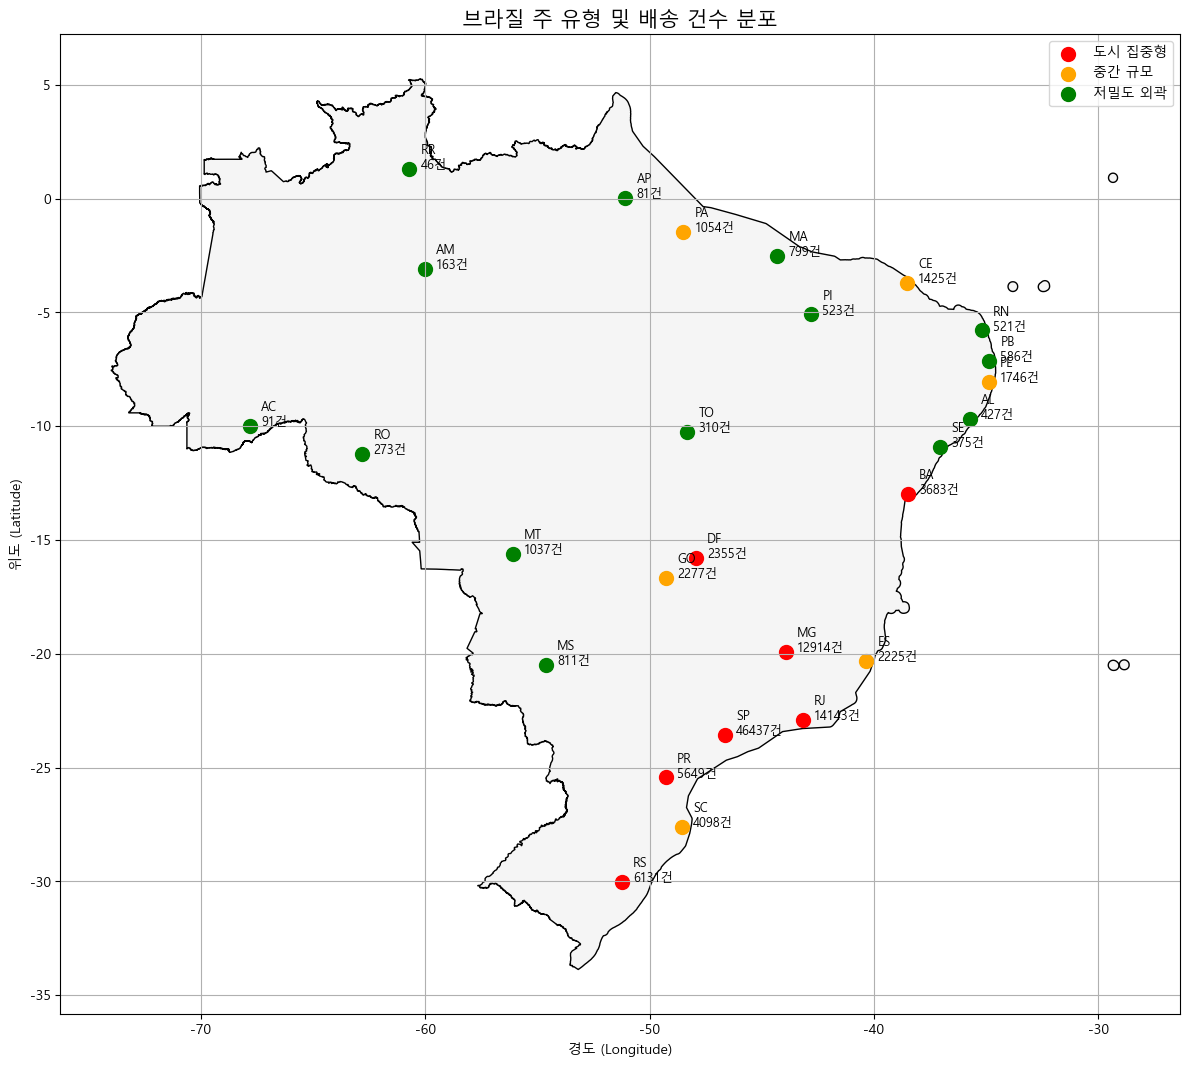

In [7]:
# 🗺️ 브라질 지도 데이터 (OpenStreetMap)
brazil = ox.geocode_to_gdf("Brazil")

# 🎯 지도 시각화
fig, ax = plt.subplots(figsize=(12, 12))

# 브라질 지도
brazil.plot(ax=ax, color="whitesmoke", edgecolor="black")

# 각 유형별 마커
gdf_urban.plot(ax=ax, color="red", markersize=100, label="도시 집중형")
gdf_mid.plot(ax=ax, color="orange", markersize=100, label="중간 규모")
gdf_low.plot(ax=ax, color="green", markersize=100, label="저밀도 외곽")

# 텍스트 표시 (주 코드 + 배송 건수)
for x, y, label, cnt in zip(gdf_all.geometry.x, gdf_all.geometry.y, gdf_all["state"], gdf_all["count"].fillna(0).astype(int)):
    ax.text(x + 0.5, y, f"{label}\n{cnt}건", fontsize=9, ha="left")

# 꾸미기
plt.title("브라질 주 유형 및 배송 건수 분포", fontsize=15)
plt.xlabel("경도 (Longitude)")
plt.ylabel("위도 (Latitude)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 📂 고객 정보 불러오기
df_customers = pd.read_csv("clean_customers.csv")

# 📂 위치 정보 (위도/경도) 원본 데이터 불러오기
df_geo = pd.read_csv("olist_geolocation_dataset.csv")

# 📌 고객의 zip_code_prefix 기준 평균 위도/경도 계산
df_geo_mean = df_geo.groupby("geolocation_zip_code_prefix")[["geolocation_lat", "geolocation_lng"]].mean().reset_index()

# 📎 고객 zip code 기준으로 병합
df_customers = df_customers.merge(
    df_geo_mean,
    left_on="customer_zip_code_prefix",
    right_on="geolocation_zip_code_prefix",
    how="left"
)

# ✅ 위도/경도 컬럼 정리
df_customers.rename(columns={"geolocation_lat": "customer_lat", "geolocation_lng": "customer_lng"}, inplace=True)

# 🔍 NaN 제거
df_customers = df_customers.dropna(subset=["customer_lat", "customer_lng"])

# 📊 클러스터링 수행 (물류센터 4곳 가정)
coords = df_customers[["customer_lat", "customer_lng"]]
kmeans = KMeans(n_clusters=4, random_state=42)
df_customers["cluster"] = kmeans.fit_predict(coords)

# 🎯 각 클러스터 중심좌표 확인
cluster_centers = kmeans.cluster_centers_
df_centers = pd.DataFrame(cluster_centers, columns=["center_lat", "center_lng"])
print("🚚 제안 물류센터 후보 좌표 (위도, 경도):")
print(df_centers)

🚚 제안 물류센터 후보 좌표 (위도, 경도):
   center_lat  center_lng
0  -22.455235  -45.597989
1   -8.749763  -38.545666
2  -26.739669  -51.045184
3  -12.874747  -50.660866


In [13]:
from shapely.geometry import Point
import geopandas as gpd

# 클러스터링 결과 예시 (위도, 경도 순서)
logistics_centers = [
    (-23.55, -46.63),  # SP 근처
    (-15.78, -47.93),  # DF 근처
    (-12.97, -38.50),  # BA 근처
    (-3.10, -60.02)    # AM 근처
]

df_centers = pd.DataFrame(logistics_centers, columns=["lat", "lng"])
df_centers["geometry"] = df_centers.apply(lambda row: Point(row["lng"], row["lat"]), axis=1)
gdf_centers = gpd.GeoDataFrame(df_centers, geometry="geometry", crs="EPSG:4326")

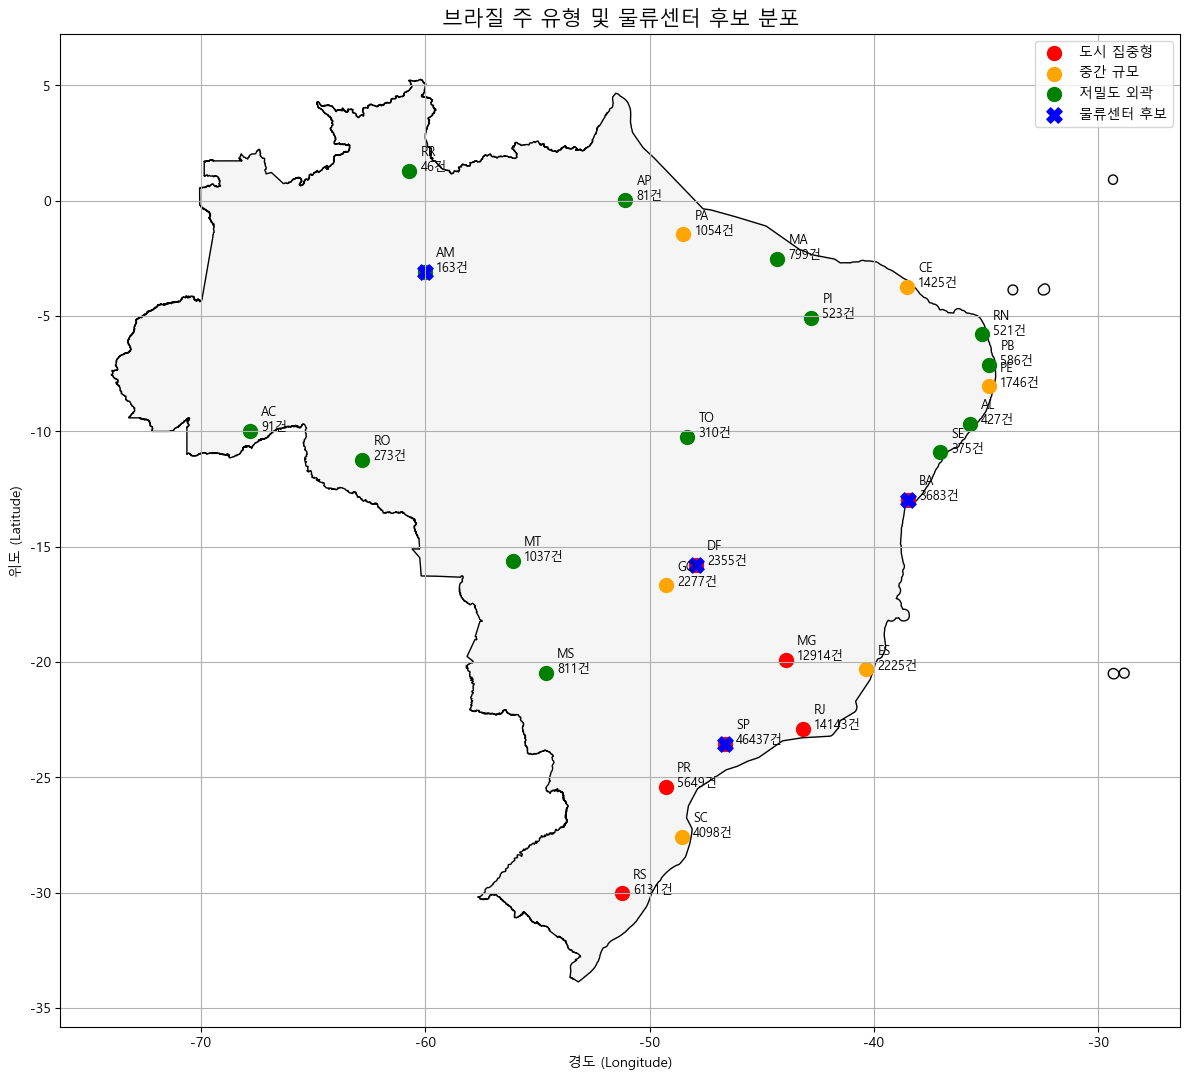

In [14]:
# 🗺️ 브라질 지도 데이터 (OpenStreetMap)
brazil = ox.geocode_to_gdf("Brazil")

# 🎯 지도 시각화
fig, ax = plt.subplots(figsize=(12, 12))

# 브라질 지도
brazil.plot(ax=ax, color="whitesmoke", edgecolor="black")

# 각 유형별 마커
gdf_urban.plot(ax=ax, color="red", markersize=100, label="도시 집중형")
gdf_mid.plot(ax=ax, color="orange", markersize=100, label="중간 규모")
gdf_low.plot(ax=ax, color="green", markersize=100, label="저밀도 외곽")

# 🔵 물류센터 위치 마커
gdf_centers.plot(ax=ax, color="blue", markersize=120, marker="X", label="물류센터 후보")

# 텍스트 표시 (주 코드 + 배송 건수)
for x, y, label, cnt in zip(gdf_all.geometry.x, gdf_all.geometry.y, gdf_all["state"], gdf_all["count"].fillna(0).astype(int)):
    ax.text(x + 0.5, y, f"{label}\n{cnt}건", fontsize=9, ha="left")

# 꾸미기
plt.title("브라질 주 유형 및 물류센터 후보 분포", fontsize=15)
plt.xlabel("경도 (Longitude)")
plt.ylabel("위도 (Latitude)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
import pandas as pd

# 📂 데이터 불러오기
df_customers = pd.read_csv("clean_customers.csv")
df_geo = pd.read_csv("olist_geolocation_dataset.csv")

# 📍 우편번호 기준 위도, 경도 평균값 계산
df_geo_grouped = df_geo.groupby("geolocation_zip_code_prefix")[["geolocation_lat", "geolocation_lng"]].mean().reset_index()

# 📎 이름 맞춰주기
df_geo_grouped.rename(columns={
    "geolocation_zip_code_prefix": "customer_zip_code_prefix",
    "geolocation_lat": "customer_lat",
    "geolocation_lng": "customer_lng"
}, inplace=True)

# 🧷 병합
df_customers = df_customers.merge(df_geo_grouped, on="customer_zip_code_prefix", how="left")

# 💾 저장 (선택)
df_customers.to_csv("clean_customers_with_coords.csv", index=False)

# 🔍 확인
print(df_customers.head())

                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  \
0                     14409                 franca             SP   
1                      9790  sao bernardo do campo             SP   
2                      1151              sao paulo             SP   
3                      8775        mogi das cruzes             SP   
4                     13056               campinas             SP   

   customer_lat  customer_lng  
0    -20.498489    -47.396929  
1    -23.727992    -46.542848  
2    -23.531642    -46.656289  
3    -23.499702   

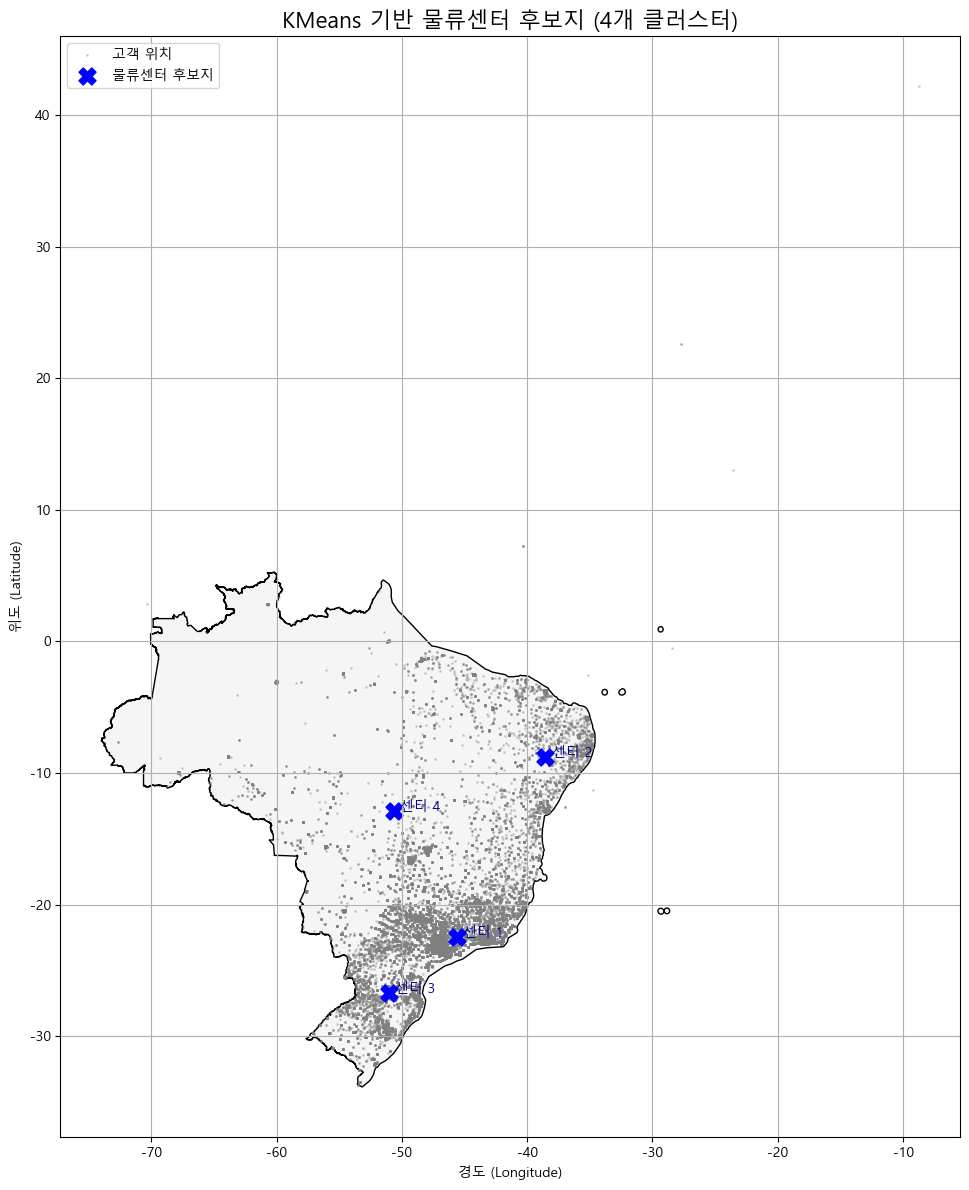

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from sklearn.cluster import KMeans
import osmnx as ox

# 📂 고객 좌표 포함된 파일 불러오기
df_customers = pd.read_csv("clean_customers_with_coords.csv")
df_customers = df_customers.dropna(subset=["customer_lat", "customer_lng"])  # 결측치 제거

# 🎯 KMeans 클러스터링 (4개의 물류센터 가정)
coords = df_customers[["customer_lat", "customer_lng"]]
kmeans = KMeans(n_clusters=4, random_state=42)
df_customers["cluster"] = kmeans.fit_predict(coords)

# 📍 클러스터 중심 추출 (물류센터 위치 후보)
centers = pd.DataFrame(kmeans.cluster_centers_, columns=["lat", "lng"])
centers["geometry"] = centers.apply(lambda row: Point(row["lng"], row["lat"]), axis=1)
gdf_centers = gpd.GeoDataFrame(centers, geometry="geometry", crs="EPSG:4326")

# 🗺️ 브라질 지도 데이터 (OpenStreetMap 사용)
brazil = ox.geocode_to_gdf("Brazil")

# 🎨 시각화
fig, ax = plt.subplots(figsize=(12, 12))

# 브라질 지도
brazil.plot(ax=ax, color="whitesmoke", edgecolor="black")

# 고객 위치 산점도
gdf_customers = gpd.GeoDataFrame(
    df_customers, 
    geometry=gpd.points_from_xy(df_customers["customer_lng"], df_customers["customer_lat"]),
    crs="EPSG:4326"
)
gdf_customers.plot(ax=ax, markersize=1, alpha=0.3, color="gray", label="고객 위치")

# 클러스터 중심점 (물류센터 후보지)
gdf_centers.plot(ax=ax, color="blue", markersize=150, marker="X", label="물류센터 후보지")

# 중심점 라벨 추가
for i, row in gdf_centers.iterrows():
    ax.text(row["geometry"].x + 0.5, row["geometry"].y, f"센터 {i+1}", fontsize=10, color="navy")

# 꾸미기
plt.title("KMeans 기반 물류센터 후보지 (4개 클러스터)", fontsize=16)
plt.xlabel("경도 (Longitude)")
plt.ylabel("위도 (Latitude)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
from sklearn.cluster import KMeans
from geopy.distance import geodesic
import numpy as np

# 1️⃣ 고객 위치 정보 준비
df_customers_coords = df_customers.copy()
geo = pd.read_csv("olist_geolocation_dataset.csv")
geo = geo.groupby("geolocation_zip_code_prefix")[["geolocation_lat", "geolocation_lng"]].mean().reset_index()

# 📌 고객 데이터에 위경도 병합
df_customers_coords = df_customers_coords.merge(
    geo, left_on="customer_zip_code_prefix", right_on="geolocation_zip_code_prefix", how="left"
)
df_customers_coords = df_customers_coords.rename(columns={
    "geolocation_lat": "customer_lat", 
    "geolocation_lng": "customer_lng"
})
df_customers_coords = df_customers_coords.dropna(subset=["customer_lat", "customer_lng"])

# 2️⃣ KMeans 클러스터링 (4개 물류센터 가정)
kmeans = KMeans(n_clusters=4, random_state=42)
coords = df_customers_coords[["customer_lat", "customer_lng"]]
df_customers_coords["cluster"] = kmeans.fit_predict(coords)

# 3️⃣ 클러스터 중심 → 물류센터 좌표
centroids = kmeans.cluster_centers_

# 4️⃣ 각 고객이 속한 클러스터 중심까지 거리 계산
def calc_distance(row):
    cluster_id = row["cluster"]
    center = centroids[cluster_id]
    return geodesic((row["customer_lat"], row["customer_lng"]), (center[0], center[1])).km

df_customers_coords["new_distance_km"] = df_customers_coords.apply(calc_distance, axis=1)

In [22]:
# 'customer_id' 기준으로 병합하여 배송 데이터에 거리 정보 추가
df = df.merge(
    df_customers_coords[["customer_id", "new_distance_km"]], 
    on="customer_id", how="left"
)

In [24]:
# 기존 배송일 평균
state_shipping_days = df.groupby("customer_state")["shipping_duration_days"].mean().reset_index()
state_shipping_days.rename(columns={"shipping_duration_days": "actual_days"}, inplace=True)

# 물류센터 기준 거리 → 예상 배송일 계산 (단순 거리 기반: 1일당 200km)
df["expected_days"] = df["new_distance_km"] / 200
state_expected_days = df.groupby("customer_state")["expected_days"].mean().reset_index()
state_expected_days["expected_days"] = state_expected_days["expected_days"].round(1)

# 병합
shipping_compare = pd.merge(state_shipping_days, state_expected_days, on="customer_state")
shipping_compare["days_saved"] = (shipping_compare["actual_days"] - shipping_compare["expected_days"]).round(1)

# 결과 출력 (caas_jupyter_tools 없이)
print(shipping_compare.sort_values("days_saved", ascending=False).round(1))

   customer_state  actual_days  expected_days  days_saved
1              AL         24.0            1.5        22.5
3              AP         27.8            7.2        20.6
24             SE         21.0            1.4        19.6
2              AM         26.0            7.5        18.5
14             PB         20.1            1.9        18.2
5              CE         20.5            2.5        18.0
21             RR         27.8           10.3        17.5
13             PA         23.3            5.9        17.4
9              MA         21.2            4.4        16.8
19             RN         18.9            2.2        16.7
4              BA         18.8            2.5        16.3
15             PE         17.8            1.7        16.1
16             PI         18.9            3.0        15.9
26             TO         17.0            2.2        14.8
12             MT         17.5            3.1        14.4
18             RJ         14.7            1.3        13.4
23            

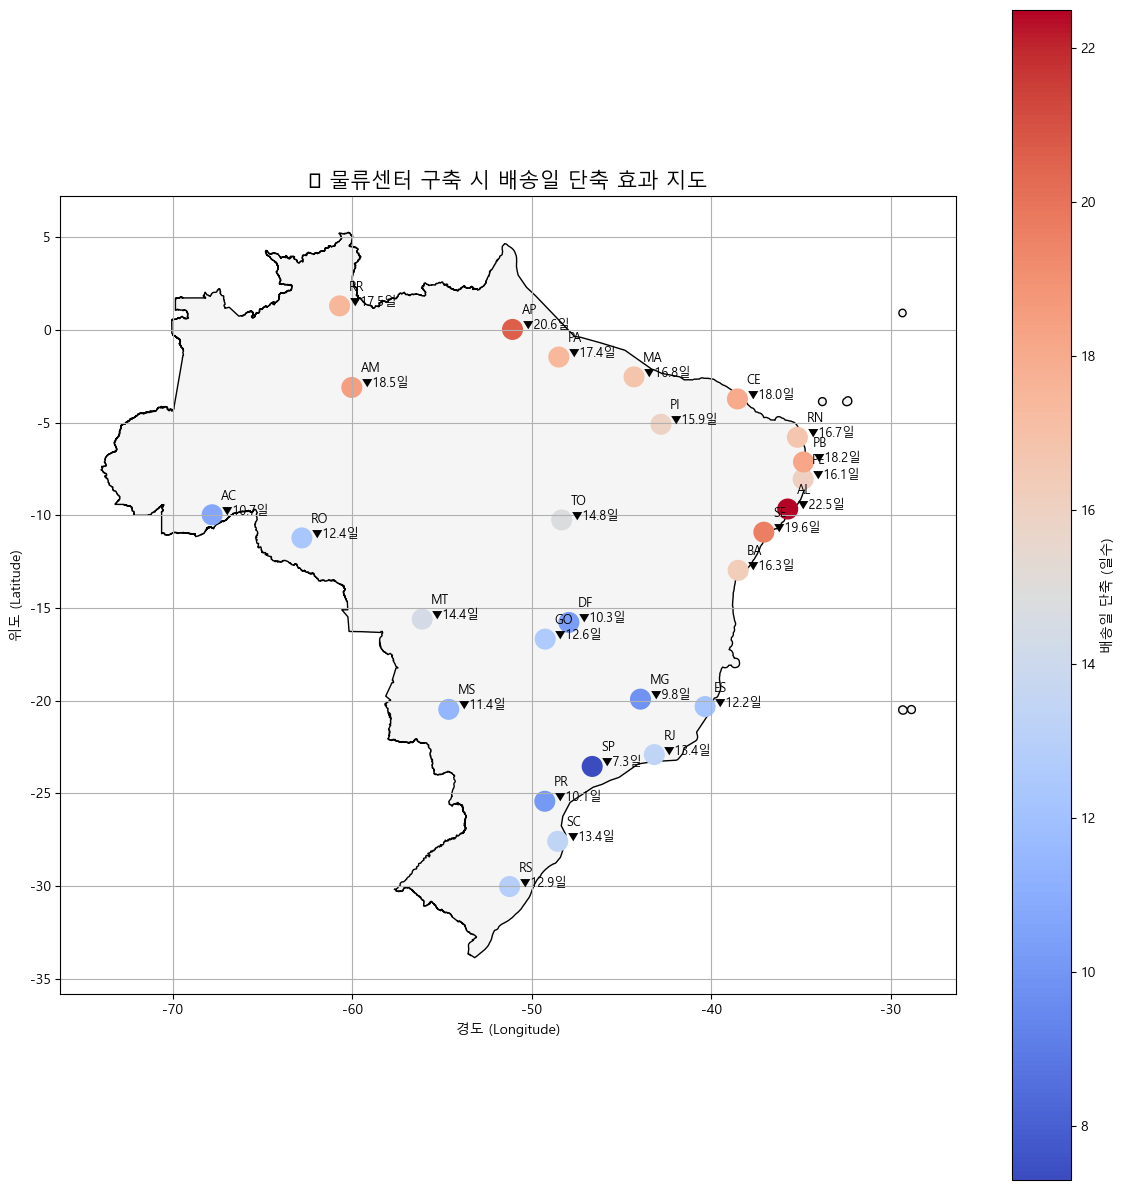

In [26]:
import matplotlib.pyplot as plt

# 배송일 단축 정보 결합
gdf_viz = gdf_all.merge(shipping_compare, how='left', left_on='state', right_on='customer_state')

# 시각화
fig, ax = plt.subplots(figsize=(12, 12))

# 브라질 지도
brazil.plot(ax=ax, color="whitesmoke", edgecolor="black")

# 배송일 단축 효과에 따른 색상 표시 (컬러맵 사용)
gdf_viz.plot(column="days_saved", cmap="coolwarm", markersize=200, legend=True, ax=ax, legend_kwds={"label": "배송일 단축 (일수)"})

# 각 주에 텍스트로 주 코드와 단축 일수 표시
for x, y, state, days in zip(gdf_viz.geometry.x, gdf_viz.geometry.y, gdf_viz["state"], gdf_viz["days_saved"]):
    if pd.notna(days):
        ax.text(x + 0.5, y, f"{state}\n▼{days:.1f}일", fontsize=9)

# 꾸미기
plt.title("📦 물류센터 구축 시 배송일 단축 효과 지도", fontsize=15)
plt.xlabel("경도 (Longitude)")
plt.ylabel("위도 (Latitude)")
plt.grid(True)
plt.tight_layout()
plt.show()

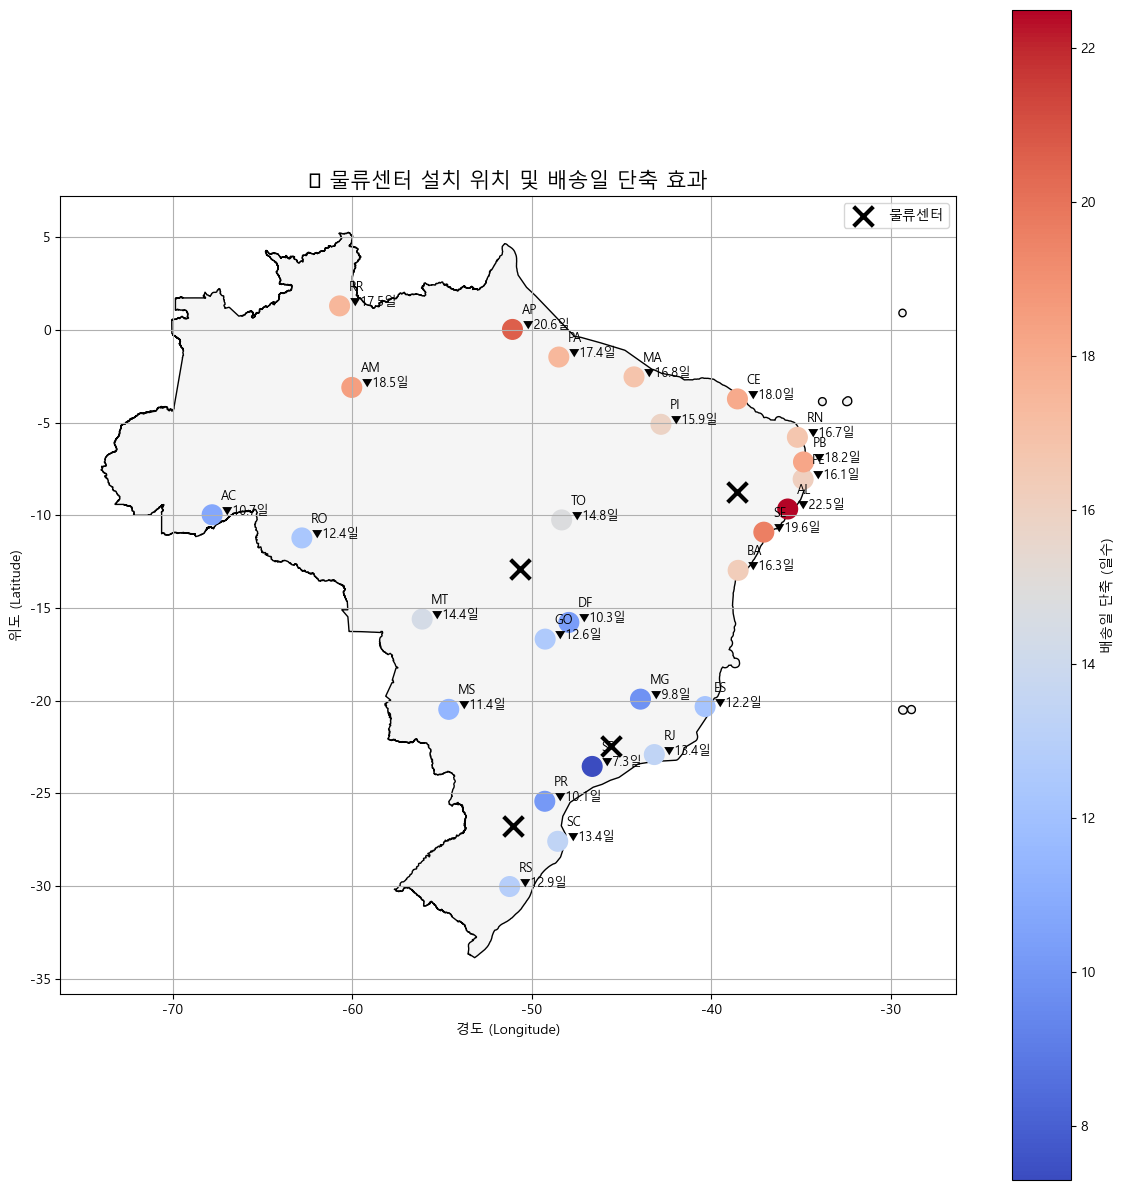

In [29]:
import matplotlib.pyplot as plt

# 브라질 지도 및 주별 배송일 단축 정보 결합
gdf_viz = gdf_all.merge(shipping_compare, how='left', left_on='state', right_on='customer_state')

# 시각화 시작
fig, ax = plt.subplots(figsize=(12, 12))

# 🗺️ 브라질 지도
brazil.plot(ax=ax, color="whitesmoke", edgecolor="black")

# 🎨 배송일 단축 색상 시각화
gdf_viz.plot(column="days_saved", cmap="coolwarm", markersize=200, legend=True, ax=ax,
             legend_kwds={"label": "배송일 단축 (일수)"})

# 📍 각 주 텍스트 표시 (주 이름 + 단축일)
for x, y, state, days in zip(gdf_viz.geometry.x, gdf_viz.geometry.y, gdf_viz["state"], gdf_viz["days_saved"]):
    if pd.notna(days):
        ax.text(x + 0.5, y, f"{state}\n▼{days:.1f}일", fontsize=9)

# ✅ 물류센터 위치 (❌ 마커) 정확히 표시 (lat, lng → lng, lat 변환)
for lat, lng in centroids:  # centroids: (lat, lng) 형식
    ax.scatter(lng, lat, color="black", marker="x", s=200, linewidths=3, label="물류센터")

# 중복된 범례 제거
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys())

# 마무리
plt.title("📦 물류센터 설치 위치 및 배송일 단축 효과", fontsize=15)
plt.xlabel("경도 (Longitude)")
plt.ylabel("위도 (Latitude)")
plt.grid(True)
plt.tight_layout()
plt.show()